---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------

## Connected components in a spatial network
### Identifying and visualizing the parts of a network

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook is a walk-through for:**

1. Instantiating a simple network with `libpysal.cg.Chain` objects
2. Working with the network components and isolated rings
3. Visualizing the components and (non)articulation vertices
4. Longest vs. Largest components
5. Extracting network components

In [1]:
%load_ext watermark
%watermark

2020-05-02T21:42:12-04:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import geopandas
import libpysal
from libpysal import examples
from libpysal.cg import Point, Chain
import matplotlib
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import spaghetti

%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
spaghetti           1.5.0.rc0
matplotlib_scalebar 0.6.1
libpysal            4.2.2
geopandas           0.7.0
matplotlib          3.1.2



In [3]:
try:
    from IPython.display import set_matplotlib_formats

    set_matplotlib_formats("retina")
except ImportError:
    pass

----------------

### 1. Instantiate a network from two collections of `libpysal.cg.Chain` objects

In [4]:
plus1 = [
    Chain([Point([1, 2]), Point([0, 2])]),
    Chain([Point([1, 2]), Point([1, 1])]),
    Chain([Point([1, 2]), Point([1, 3])]),
]
plus2 = [
    Chain([Point([2, 1]), Point([2, 0])]),
    Chain([Point([2, 1]), Point([3, 1])]),
    Chain([Point([2, 1]), Point([2, 2])]),
]
lines = plus1 + plus2

In [5]:
ntw = spaghetti.Network(in_data=lines)

/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


#### Here we get a warning because the network we created is not fully connected

In [6]:
ntw.network_fully_connected

False

#### It has 2 connected components

In [7]:
ntw.network_n_components

2

#### The network components can be inspected through the following attributes
##### `network_component_labels`

In [8]:
ntw.network_component_labels

array([0, 0, 0, 1, 1, 1], dtype=int32)

##### `network_component2arc` 

In [9]:
ntw.network_component2arc

{0: [(0, 1), (0, 2), (0, 3)], 1: [(4, 5), (4, 6), (4, 7)]}

##### `network_component_lengths`

In [10]:
ntw.network_component_lengths

{0: 3.0, 1: 3.0}

##### `network_longest_component`

In [11]:
ntw.network_longest_component

0

##### `network_component_vertices` 

In [12]:
ntw.network_component_vertices

{0: [0, 1, 2, 3], 1: [4, 5, 6, 7]}

##### `network_component_vertex_count` 

In [13]:
ntw.network_component_vertex_count

{0: 4, 1: 4}

##### `network_largest_component` 

In [14]:
ntw.network_largest_component

0

##### `network_component_is_ring` 

In [15]:
ntw.network_component_is_ring

{0: False, 1: False}

#### The same can be performed for graph representations, for example:
##### `graph_component_labels`

In [16]:
ntw.graph_component_labels

array([0, 0, 0, 1, 1, 1], dtype=int32)

##### `graph_component2edge` 

In [17]:
ntw.graph_component2edge

{0: [(0, 1), (0, 2), (0, 3)], 1: [(4, 5), (4, 6), (4, 7)]}

#### Extract the network arc and vertices as `geopandas.GeoDataFrame` objects

In [18]:
# network vertices and arcs
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

#### Network component labels are found in the `"comp_label"` field

In [19]:
vertices_df

,id,geometry,comp_label
0,0,POINT (1.00000 2.00000),0
1,1,POINT (0.00000 2.00000),0
2,2,POINT (1.00000 1.00000),0
3,3,POINT (1.00000 3.00000),0
4,4,POINT (2.00000 1.00000),1
5,5,POINT (2.00000 0.00000),1
6,6,POINT (3.00000 1.00000),1
7,7,POINT (2.00000 2.00000),1


In [20]:
arcs_df

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (1.00000 2.00000, 0.00000 2.00000)",0
1,"(0, 2)","LINESTRING (1.00000 2.00000, 1.00000 1.00000)",0
2,"(0, 3)","LINESTRING (1.00000 2.00000, 1.00000 3.00000)",0
3,"(4, 5)","LINESTRING (2.00000 1.00000, 2.00000 0.00000)",1
4,"(4, 6)","LINESTRING (2.00000 1.00000, 3.00000 1.00000)",1
5,"(4, 7)","LINESTRING (2.00000 1.00000, 2.00000 2.00000)",1


#### Plot the disconnected network and symbolize the arcs bases on the value of `"comp_label"`

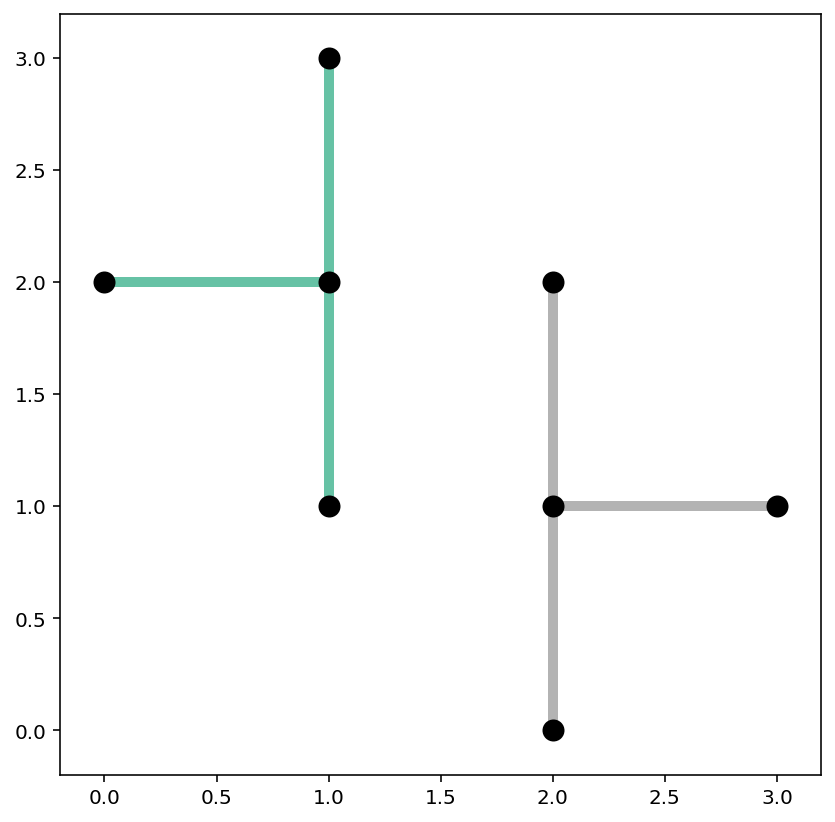

In [21]:
base = arcs_df.plot(column="comp_label", cmap="Set2", linewidth=5, figsize=(7, 7))
vertices_df.plot(ax=base, color="k", markersize=100, zorder=2);


----------------

### 2. Add to the network created above

In [22]:
new_lines = [
    Chain([Point([1, 1]), Point([2, 2])]),
    Chain([Point([0.5, 1]), Point([0.5, 0.5])]),
    Chain([Point([0.5, 0.5]), Point([1, 0.5])]),
    Chain([Point([2, 2.5]), Point([2.5, 2.5])]),
    Chain([Point([2.5, 2.5]), Point([2.5, 2])]),
]
lines += new_lines

In [23]:
ntw = spaghetti.Network(in_data=lines)

/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: (8, 10), (11, 13).
  warnings.warn(message)


#### Now there are 3 connected components in the network

In [24]:
ntw.network_n_components

3

In [25]:
ntw.network_component2arc

{0: [(0, 1), (0, 2), (0, 3), (2, 7), (4, 5), (4, 6), (4, 7)],
 1: [(8, 9), (9, 10)],
 2: [(11, 12), (12, 13)]}

In [26]:
# network vertices and arcs
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

In [27]:
arcs_df

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (1.00000 2.00000, 0.00000 2.00000)",0
1,"(0, 2)","LINESTRING (1.00000 2.00000, 1.00000 1.00000)",0
2,"(0, 3)","LINESTRING (1.00000 2.00000, 1.00000 3.00000)",0
3,"(2, 7)","LINESTRING (1.00000 1.00000, 2.00000 2.00000)",0
4,"(4, 5)","LINESTRING (2.00000 1.00000, 2.00000 0.00000)",0
5,"(4, 6)","LINESTRING (2.00000 1.00000, 3.00000 1.00000)",0
6,"(4, 7)","LINESTRING (2.00000 1.00000, 2.00000 2.00000)",0
7,"(8, 9)","LINESTRING (0.50000 1.00000, 0.50000 0.50000)",1
8,"(9, 10)","LINESTRING (0.50000 0.50000, 1.00000 0.50000)",1
9,"(11, 12)","LINESTRING (2.00000 2.50000, 2.50000 2.50000)",2


#### We can also inspect the non-articulation points in the network. Non-articulation points are vertices in a network that are degree-2. A vertex is degree-2 if, and only if, it is directly connected to only 2 other vertices.

In [28]:
ntw.non_articulation_points

[9, 2, 12, 7]

#### Slice out the articulation points and non-articulation points

In [29]:
napts = ntw.non_articulation_points
articulation_vertices = vertices_df[~vertices_df["id"].isin(napts)]
non_articulation_vertices = vertices_df[vertices_df["id"].isin(napts)]

#### Plot the connected components while making a distinction between articulation points and non-articulation points

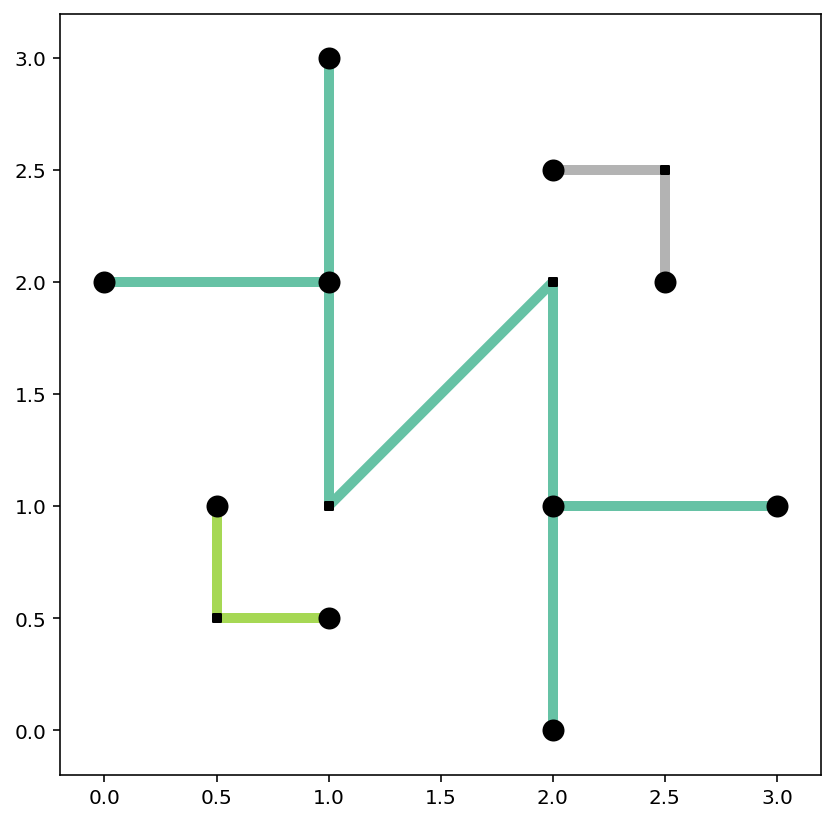

In [30]:
base = arcs_df.plot(column="comp_label", cmap="Set2", linewidth=5, figsize=(7, 7))
articulation_vertices.plot(ax=base, color="k", markersize=100, zorder=2)
non_articulation_vertices.plot(ax=base, marker="s", color="k", markersize=20, zorder=2);

----------------

### 3. Add a loop of `libpysal.cg.Chain` objects

In [31]:
new_lines = [
    Chain([Point([3, 1]), Point([3.25, 1.25])]),
    Chain([Point([3.25, 1.25]), Point([3.5, 1.25])]),
    Chain([Point([3.5, 1.25]), Point([3.75, 1])]),
    Chain([Point([3.75, 1]), Point([3.5, 0.75])]),
    Chain([Point([3.5, 0.75]), Point([3.25, 0.75])]),
    Chain([Point([3.25, 0.75]), Point([3, 1])]),
]
lines += new_lines

In [32]:
ntw = spaghetti.Network(in_data=lines)

/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: (8, 10), (11, 13).
  warnings.warn(message)


In [33]:
ntw.network_n_components

3

In [34]:
ntw.network_component2arc

{0: [(0, 1),
  (0, 2),
  (0, 3),
  (2, 7),
  (4, 5),
  (4, 6),
  (4, 7),
  (6, 14),
  (6, 18),
  (14, 15),
  (15, 16),
  (16, 17),
  (17, 18)],
 1: [(8, 9), (9, 10)],
 2: [(11, 12), (12, 13)]}

In [35]:
# network vertices and arcs
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

In [36]:
arcs_df

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (1.00000 2.00000, 0.00000 2.00000)",0
1,"(0, 2)","LINESTRING (1.00000 2.00000, 1.00000 1.00000)",0
2,"(0, 3)","LINESTRING (1.00000 2.00000, 1.00000 3.00000)",0
3,"(2, 7)","LINESTRING (1.00000 1.00000, 2.00000 2.00000)",0
4,"(4, 5)","LINESTRING (2.00000 1.00000, 2.00000 0.00000)",0
5,"(4, 6)","LINESTRING (2.00000 1.00000, 3.00000 1.00000)",0
6,"(4, 7)","LINESTRING (2.00000 1.00000, 2.00000 2.00000)",0
7,"(6, 14)","LINESTRING (3.00000 1.00000, 3.25000 1.25000)",0
8,"(6, 18)","LINESTRING (3.00000 1.00000, 3.25000 0.75000)",0
9,"(8, 9)","LINESTRING (0.50000 1.00000, 0.50000 0.50000)",1


#### Here we can see that all the new network vertices are non-articulation point

In [37]:
ntw.non_articulation_points

[2, 7, 9, 12, 14, 15, 16, 17, 18]

#### Slice out the articulation points and non-articulation points

In [38]:
napts = ntw.non_articulation_points
articulation_vertices = vertices_df[~vertices_df["id"].isin(napts)]
non_articulation_vertices = vertices_df[vertices_df["id"].isin(napts)]

#### The new network vertices are non-articulation points because they form a closed ring

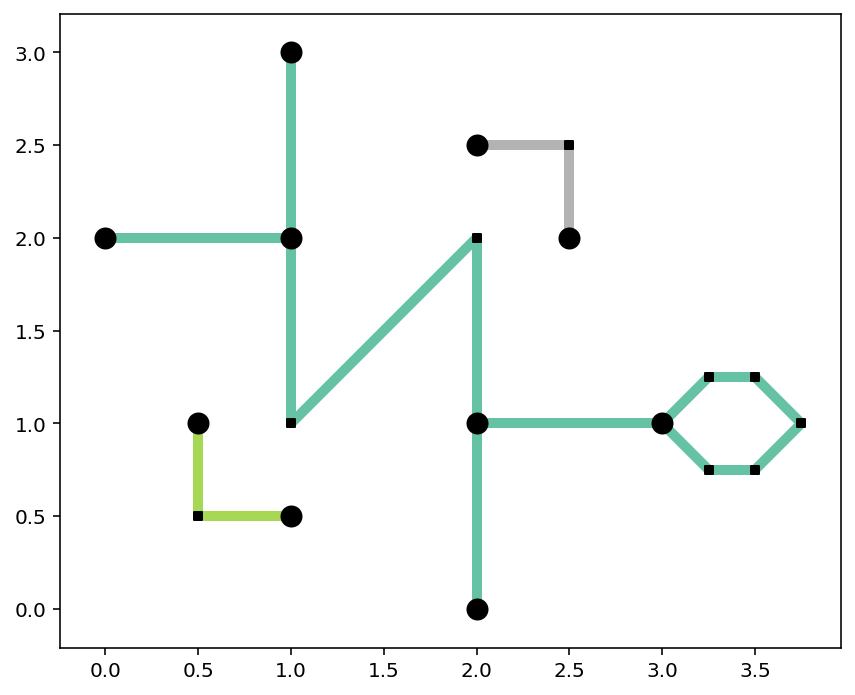

In [39]:
base = arcs_df.plot(column="comp_label", cmap="Set2", linewidth=5, figsize=(7, 7))
articulation_vertices.plot(ax=base, color="k", markersize=100, zorder=2)
non_articulation_vertices.plot(ax=base, marker="s", color="k", markersize=20, zorder=2);

-----------------------------------------------------

### 4. Longest vs. largest components — cross vs. hexagon

In [40]:
cross = [
    Chain([Point([0, 5]), Point([5, 5]), Point([5, 10])]),
    Chain([Point([5, 0]), Point([5, 5]), Point([10, 5])]),
]
hexagon = [
    Chain(
        [
            Point([12, 5]),
            Point([13, 6]),
            Point([14, 6]),
            Point([15, 5]),
            Point([14, 4]),
            Point([13, 4]),
            Point([12, 5]),
        ]
    ),
]
lines = cross + hexagon

In [41]:
ntw = spaghetti.Network(in_data=lines)

/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [42]:
# network vertices and arcs
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

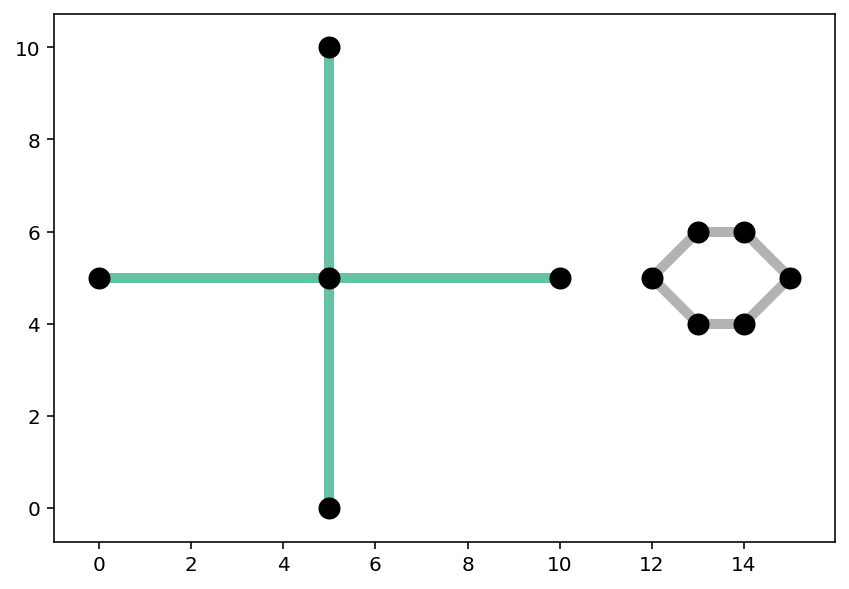

In [43]:
base = arcs_df.plot(column="comp_label", cmap="Set2", linewidth=5, figsize=(7, 7))
vertices_df.plot(ax=base, color="k", markersize=100, zorder=2);

#### The longest component is not necessarily the largest
##### This is because in `spaghetti` the largest compnent equates to the most vertices

In [44]:
clongest = ntw.network_longest_component
clength = round(ntw.network_component_lengths[clongest], 5)
clargest = ntw.network_largest_component
cverts = ntw.network_component_vertex_count[clargest]
print("The longest component is %s at %s units of distance." % (clongest, clength))
print("The largest component is %s with %s vertices." % (clargest, cverts))

The longest component is 0 at 20.0 units of distance.
The largest component is 1 with 6 vertices.


### 5. Extracting components
#### Extract the longest component

In [45]:
longest = spaghetti.extract_component(ntw, ntw.network_longest_component)

In [46]:
# network vertices and arcs
vertices_df, arcs_df = spaghetti.element_as_gdf(longest, vertices=True, arcs=True)

In [47]:
vertices_df

,id,geometry,comp_label
0,0,POINT (0.00000 5.00000),0
1,1,POINT (5.00000 5.00000),0
2,2,POINT (5.00000 10.00000),0
3,3,POINT (5.00000 0.00000),0
4,4,POINT (10.00000 5.00000),0


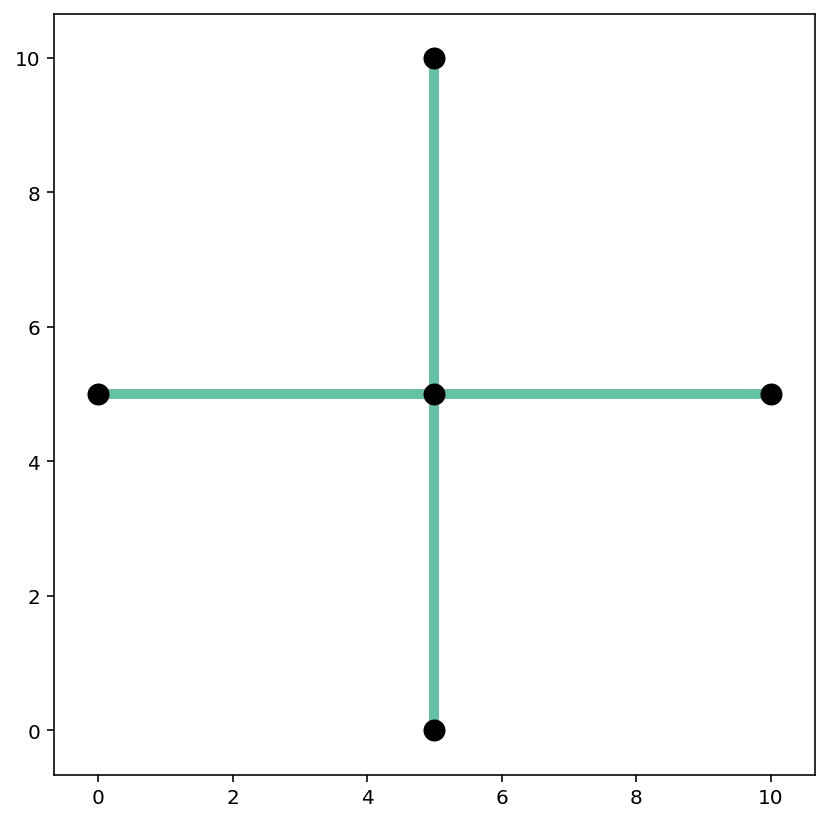

In [48]:
base = arcs_df.plot(column="comp_label", cmap="Set2", linewidth=5, figsize=(7, 7))
vertices_df.plot(ax=base, color="k", markersize=100, zorder=2);

#### Extract the largest component and plot

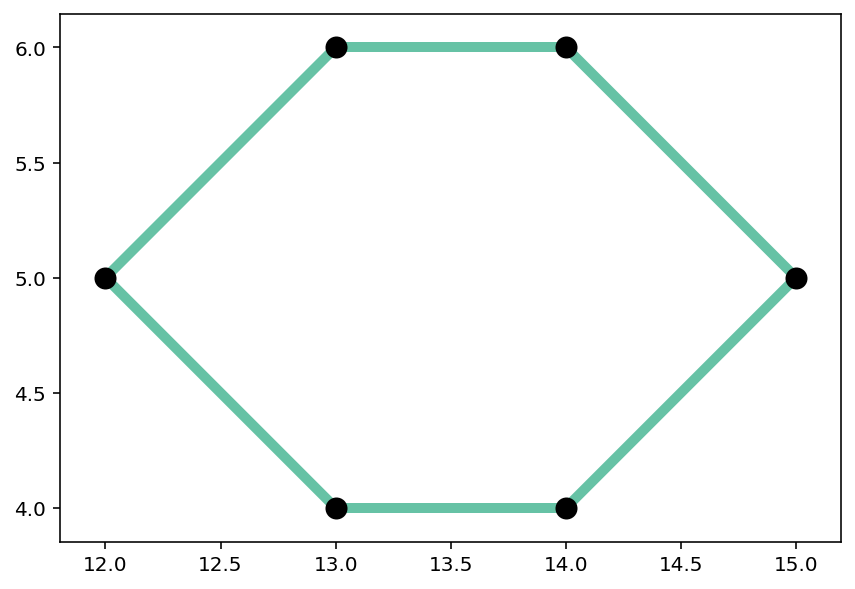

In [49]:
largest = spaghetti.extract_component(ntw, ntw.network_largest_component)
# network vertices and arcs
vertices_df, arcs_df = spaghetti.element_as_gdf(largest, vertices=True, arcs=True)
base = arcs_df.plot(column="comp_label", cmap="Set2", linewidth=5, figsize=(7, 7))
vertices_df.plot(ax=base, color="k", markersize=100, zorder=2);

#### Empirical Example — New Haven, Connecticut

In [50]:
newhaven = libpysal.examples.get_path("newhaven_nework.shp")
ntw = spaghetti.Network(in_data=newhaven, extractgraph=False)

/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
 There are 7 islands with ids: (1494, 1495), (2129, 2130), (3756, 3757), (8669, 8670), (9611, 9612), (11152, 11153), (11228, 11229).
  warnings.warn(message)


#### Extract the longest component

In [51]:
longest = spaghetti.extract_component(ntw, ntw.network_longest_component)

In [52]:
# network vertices and arcs
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
arcs_df.crs = "epsg:4269"
arcs_df = arcs_df.to_crs("epsg:6433")

In [53]:
# longest vertices and arcs
lc_vertices, lc_arcs = spaghetti.element_as_gdf(longest, vertices=True, arcs=True)
lc_arcs.crs = "epsg:4269"
lc_arcs = lc_arcs.to_crs("epsg:6433")

#### Filter non-longest component arcs

In [54]:
nlc = ntw.network_longest_component
arcs_df = arcs_df[arcs_df.comp_label != nlc]
ocomp = list(set(ntw.network_component_labels))
ocomp.remove(nlc)

#### Plot network arcs

In [55]:
def legend(objects):
    """Add a legend to a plot"""
    patches = make_patches(*objects)
    kws = {"fancybox": True, "framealpha": 0.85, "fontsize": "x-large"}
    kws.update({"loc": "lower left", "labelspacing": 2.0, "borderpad": 2.0})
    legend = matplotlib.pyplot.legend(handles=patches, **kws)
    legend.get_frame().set_facecolor("white")

In [56]:
def make_patches(comp_type, in_comp, oc):
    """Create patches for legend"""
    labels_colors_alpha = [
        ["%s component: %s" % (comp_type.capitalize(), in_comp), "k", 0.5],
        ["Other components: %s-%s" % (oc[0], oc[1]), "r", 1],
    ]
    patches = []
    for l, c, a in labels_colors_alpha:
        p = matplotlib.lines.Line2D([], [], lw=2, label=l, c=c, alpha=a)
        patches.append(p)
    return patches

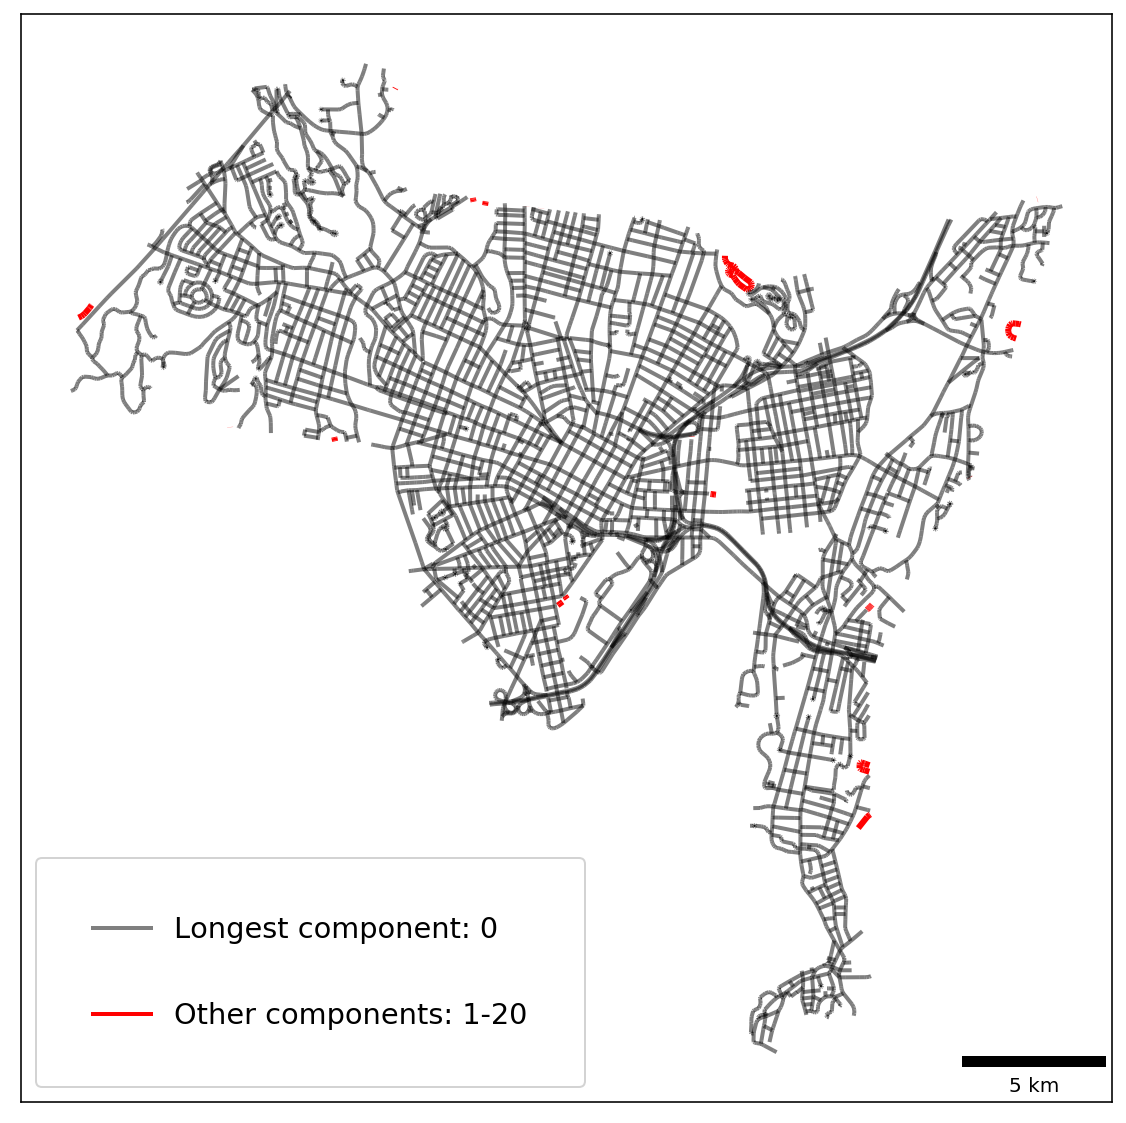

In [57]:
base = arcs_df.plot(color="r", alpha=1, linewidth=3, figsize=(10, 10))
lc_arcs.plot(ax=base, color="k", linewidth=2, alpha=0.5, zorder=2)
# add legend
legend(("longest", nlc, (ocomp[0], ocomp[-1])))
# add scale bar
scalebar = ScaleBar(3, units="m", location="lower right")
base.add_artist(scalebar)
base.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

---------------------------------------